<a href="https://colab.research.google.com/github/yumzi41/ProjetL1/blob/master/probleme2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/yumzi41/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import *

fatal: destination path 'exam_2025' already exists and is not an empty directory.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


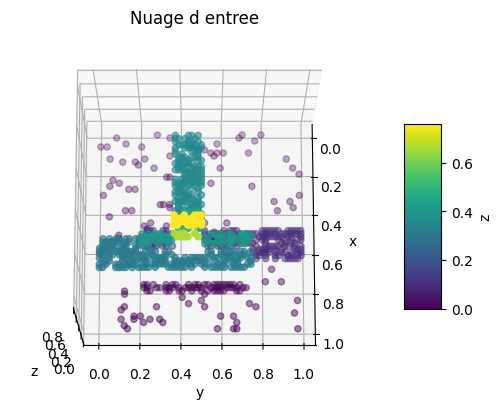

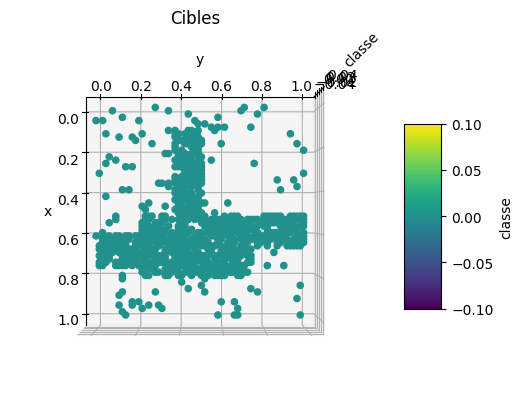

1


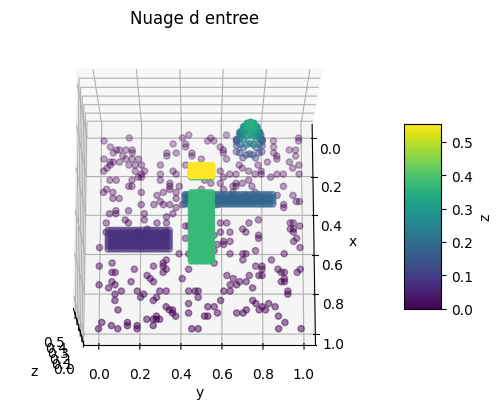

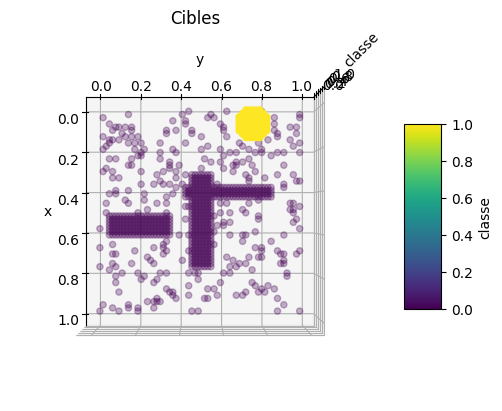

2


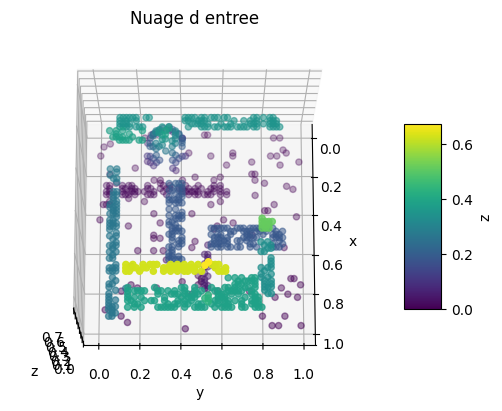

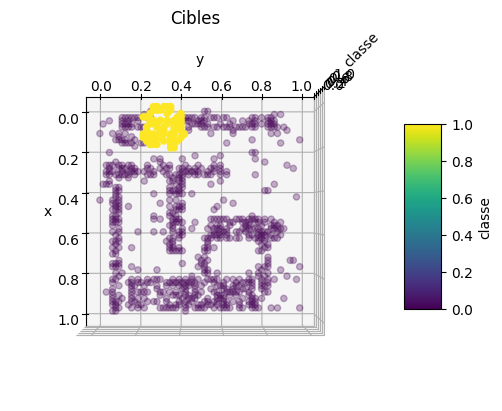

3


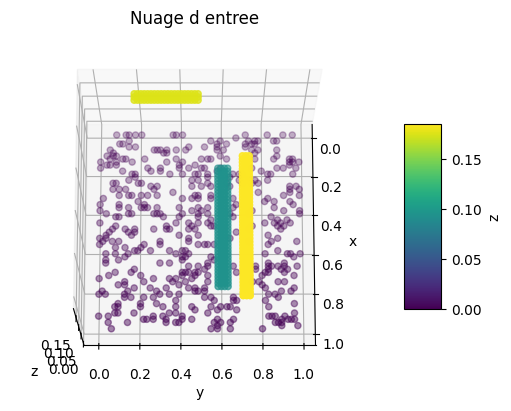

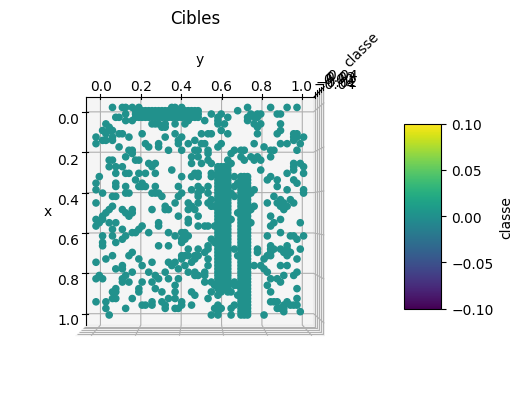

4


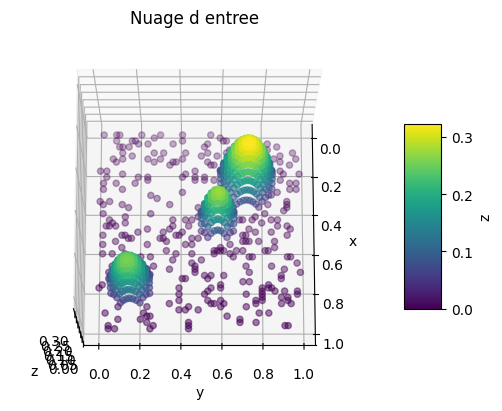

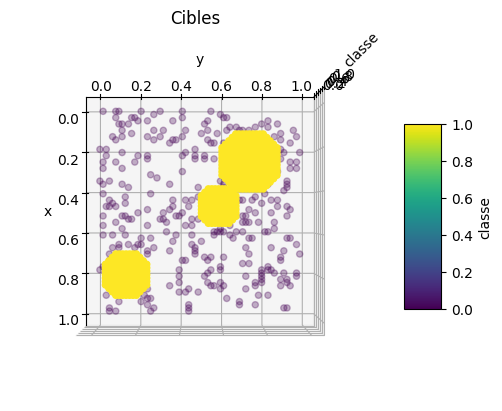

5


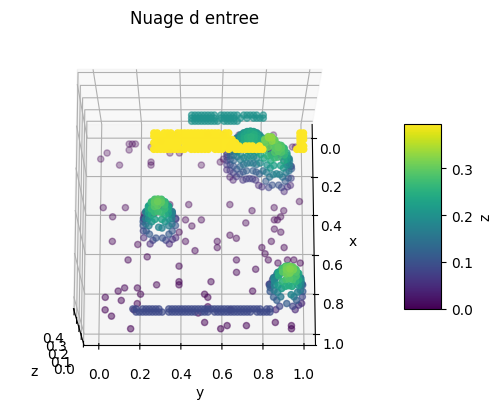

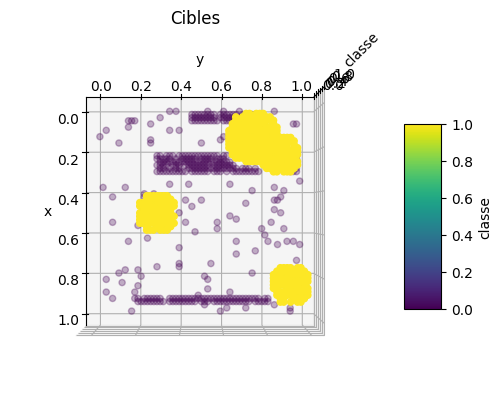

In [10]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

## Q1 : À quoi correspondent les différentes dimensions de *input_points* ?

Dans le code, la fonction `gen_pointcloud` renvoie trois tenseurs : `(ux, uy, xy)`.

- `ux` correspond à `input_points`.
- `uy` correspond à `target_list` (ou une forme de label 1D par point).
- `xy` est un tenseur similaire à `ux`, mais combinant deux coordonnées `(x, y)` et la hauteur `(z)` d’une autre façon.

Les dimensions de `input_points` (`ux`) sont :  
**`(batch_size, 3, M)`**

- **`batch_size`** : le nombre d’échantillons dans le batch (6 dans cet exemple).
- **`3`** : représente les trois coordonnées `(x, y, z)` de chaque point.
- **`M`** : le nombre total de points échantillonnés dans chaque nuage.

Chaque échantillon dans le batch contient donc un nuage de `M` points, chacun décrit par trois coordonnées `(x, y, z)`.


**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

## Q2 : Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Non, les points d'un nuage ne sont pas rangés dans un ordre particulier.

Dans les fonctions `get_random_xy_triplets` et `get_random_triplets`, les indices des points non nuls et des points nuls sont mélangés aléatoirement à l’aide de `torch.randperm`. Après ce mélange, les points sont concaténés en sortie.

L’ordre final des points dans le nuage est donc **aléatoire** et ne suit pas de schéma spatial particulier.


**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

## Q3 : Approches possibles avec un FCN ou un ViT pour ce problème

### Approche avec un FCN (Fully Convolutional Network)

Pour utiliser un FCN, il faudrait d'abord convertir le nuage de points en une image 2D.  
Voici une méthode possible :

1. **Projeter le nuage de points** `(x, y, z)` sur une grille 2D, en choisissant une résolution (par exemple 64x64).
2. Pour chaque point `(x, y)`, attribuer la valeur de l’altitude `z` (ou plusieurs canaux, comme la hauteur moyenne, etc.).
3. Entraîner un FCN sur cette image 2D, avec une segmentation binaire :  
   - **Classe 1** : les points correspondant aux igloos.  
   - **Classe 0** : les points correspondant aux autres surfaces (sol et toits plats).

---

### Approche avec un ViT (Vision Transformer)

Les Vision Transformers (ViTs) traitent des séquences de tokens. Voici deux stratégies possibles :

1. **Transformer le nuage de points en une image 2D** comme dans l’approche FCN, puis découper cette image en patches, que le ViT pourra traiter.
   
2. **Utiliser directement les points comme séquence** :  
   - Représenter chaque point `(x, y, z)` sous forme d’un vecteur d’embedding via un MLP.  
   - Construire une séquence de ces embeddings pour chaque nuage.  
   - Appliquer un ViT ou un Point Transformer pour classifier chaque point en **igloo** ou **non-igloo**.

---

Ces deux approches peuvent être adaptées selon les spécificités des données et des objectifs de segmentation.


## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [11]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)


**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

# **Q1 : Dimensions de la sortie et impact d'une permutation**

Dans le cadre de la segmentation, le **PointNetSegHead** renvoie un tuple
`(output, crit_idxs, A_feat)` où :
- `output` est de taille \((B, N, M)\) :
  - \( B \) est la taille de batch,
  - \( N \) est le nombre de points d'entrée,
  - \( M \) est le nombre de classes pour la segmentation.
- `crit_idxs` contient les index critiques associés au *max-pooling* dans l'architecture *PointNet* (utiles pour certaines méthodes d'explicabilité).
- `A_feat` est la matrice de transformation (T-Net) dans l'espace des features (64D), utilisée pour la régularisation orthogonale.

---

## **Pourquoi ces dimensions ?**

Comme présenté dans l’article, l’architecture *PointNet* fonctionne point par point par le biais de convolutions 1D (MLP partagés). Ensuite, la couche de *max-pooling* \(\max\)-agrège les caractéristiques (\(N\) points \(\rightarrow\) un vecteur global de taille 1024 par défaut). Pour la **segmentation**, ces **caractéristiques globales** sont **concaténées** (ou combinées) aux **features locales** (64D) afin de prédire la classe de chaque point de façon indépendante. C’est pourquoi la sortie finale, pour la segmentation, doit retrouver la taille \((B, N, M)\).

---

## **Effet d’une permutation des points d’entrée**

1. **Permutation des points**  
   Une propriété clé de *PointNet* est d'être **invariant** (classification) ou **équivariant** (segmentation) vis-à-vis de l’ordre des points.  
   - En **classification**, étant donné qu’on opère un \(\max\)-pooling global, l’ordre des points dans le nuage n’influence pas la **valeur agrégée** finale du réseau (invariance).  
   - En **segmentation**, l’**indice** du point est conservé à travers toutes les couches (chaque colonne de features correspond au même point). Ainsi, si l’on permute l’ordre des points en entrée, on obtient la **même prédiction**, mais **permutée** selon le même ordre dans la sortie (équivariance).  

2. **Vérification par l'expérience**  
   On peut faire des permutations aléatoires (\(`torch.randperm`\)) sur `input_points` et observer que la forme de la sortie \((B, N, M)\) ne change pas. De plus, la sortie pour chaque point subira la **même permutation**.

La cellule de code suivante illustre comment permuter l'ordre des points et vérifier que la sortie reste cohérente.


In [12]:
import torch

def test_pointnet_permutation(model, input_points):
    """
    Illustrer l'invariance/équivariance de PointNet vis-à-vis de la permutation
    """
    # On récupère la sortie initiale
    output, _, _ = model(input_points)

    # On permute les points de chaque nuage
    B, C, N = input_points.shape
    perm = torch.randperm(N).to(input_points.device)
    input_points_permuted = input_points[:, :, perm]

    # On repasse dans le réseau
    output_permuted, _, _ = model(input_points_permuted)

    # Affichage des formes pour vérifier l'équivalence
    print(f"Sortie originale    : shape = {output.shape}")
    print(f"Sortie permutée     : shape = {output_permuted.shape}")
    print("Observations :")
    print(" - La forme (B, N, M) ne change pas.")
    print(" - Les valeurs pour chaque point sont simplement réarrangées suivant la permutation.")

# Exemple d'utilisation :
test_pointnet_permutation(pointnet, input_points)


Sortie originale    : shape = torch.Size([6, 800, 2])
Sortie permutée     : shape = torch.Size([6, 800, 2])
Observations :
 - La forme (B, N, M) ne change pas.
 - Les valeurs pour chaque point sont simplement réarrangées suivant la permutation.


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

# **Q2 : Opérations menant à la segmentation (hors "input transform" et "feature transform")**

La **Figure 2** de l’article [*PointNet*](https://arxiv.org/abs/1612.00593) met en évidence plusieurs opérations, à la fois pour la classification et pour la segmentation, et fait apparaître deux *T-Nets* (transformations) qu'on ignore ici pour se concentrer sur les autres étapes. Dans le *bloc* dédié à la segmentation, hors transformation, on retrouve :

1. **MLP 1**  
   Un réseau de **perceptrons multicouches** (MLP) appliqué _indépendamment_ à chaque point $64, 64$.  
   Le terme "*shared*" ($\text{MLP}_{\text{shared}}$) indique que **les mêmes poids** sont utilisés pour tous les points.  
   Concrètement, pour chaque point $\mathbf{x}_i$, on applique la même fonction $\phi$. Cela permet de traiter chaque point de façon identique.

2. **MLP 2**  
   Un second MLP $64, 128, 1024$ (toujours partagé) pour extraire des descripteurs de plus haut niveau sur chaque point.

3. **Max Pooling**  
   Une opération de **max** (aggrégation) qui **récupère le maximum** sur la dimension des points, donnant ainsi un **descripteur global** de taille 1024.  
   Cette opération est **invariante** à l'ordre des points : quelle que soit la permutation de l’entrée, le maximum par canal reste le même.

4. **Concatenation / Assemblage**  
   Dans la tête de **segmentation**, on concatène (ou agrège) le descripteur global (obtenu par max-pooling) avec des *features* locales (par exemple, les 64 dimensions précédentes) pour construire un tenseur $n \times 1088$ dans l’article (ou équivalent selon l’implémentation).  
   Chaque point reçoit donc à la fois **ses propres caractéristiques locales** et la **caractéristique globale** extraite du nuage entier.

5. **MLP final**  
   Un nouveau MLP $512, 256, 128, m$ qui **prédit la classe** de chaque point (où $m$ est le nombre de classes).  
   Comme précédemment, il est **partagé** pour tous les points, et s’applique donc indépendamment à chacun.

---

## **Signification de "shared"**

Le terme "*shared*" (ou *weight sharing*) signifie que le **même réseau** (mêmes poids) est appliqué à chacun des $n$ points. Autrement dit, on ne construit pas un MLP différent pour chaque point, mais on emploie _une fonction_ $\phi$ identique pour tous les points.  

### **Invariance à l’ordre des points**  
Le fait d'appliquer la même fonction aux points, puis de réaliser un **max-pooling** (pour extraire un descripteur global) assure l’**invariance** (en classification) ou l’**équivariance** (en segmentation) vis-à-vis de l’ordre dans lequel les points sont présentés :

- **Invariance pour la classification** : Le max-pooling génère le même vecteur global, quel que soit l’ordre d’itération des points.
- **Équivariance pour la segmentation** : À la sortie, le point d’indice $i$ reçoit sa prédiction associée. Si on permute les points en entrée, la sortie est **permise** de la même façon, et reste donc cohérente.


<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [15]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, size_average=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

TypeError: cannot assign 'numpy.ndarray' object to buffer 'weight' (torch Tensor or None required)

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
